# Balanced two-way ANOVA

This page follows on from the [one-way ANOVA notebook](./oneway_diets.ipynb).

Please make sure you follow the one-way ANOVA notebook before you read this notebook, because we are going to re-use a not of notation and machinery from that notebook.

In the one-way notebook, we considered the situation where we had three groups, and, for each group, we have a certain number of values.  In our particular case, we had measures of the amount of weight lost by groups of people following three different diets.

We call this grouping of individuals into Diets — a *factor*.  The `diet`
column allocates a label to each individual, one of `A` or `B` or `C`.   We
call the possible labels of the `diet` factor — *levels*.   Thus the `diet`
factor has 3 levels, `A`, `B` and `C`.

We found that the ANOVA test asks whether the *means* of the observations
within groups are convincingly different from the overall mean.

In fact, the data we used from for the one-way ANOVA page has another grouping
— `gender`. This records whether the person on the diet was `Female` or `Male.`

This means that we have can classify the individuals (rows) with two factors:
`gender` and `diet`.  `gender` has two levels — `Female` and `Male`.  `diet`
has three levels — `A`, `B`, and `C`.   We now have 2 * 3 = 6 groups to
classify the individuals — (`Female`, `A`), (`Female`, `B`), and so on, through
to (`Male`, `C`).

One method of analyzing such data is the two-way Analysis of Variance (ANOVA).  It generalizes the one-way ANOVA by looking at the means for the levels of the different factors, and the means for each of the (here) six groups.

It turns out that doing that has some complications when there are different
number of individuals in the six groups.  So, as so often in statistics
tutorials, we start by cheating, and chopping our data down to the simpler
situation where there is an equal number of individuals in each of the six
groups.  The simpler case is called a *balanced* ANOVA.  Once we have done
that, it is fairly easy to replicate the F statistic values by hand, using the
logic you have already seen in the one-way ANOVA page.  That is what we do in
this page.  In the next page, we will start to go to the black-run and
off-piste, to think about what would happen in the more typical case, where
there are different numbers of individuals in the groups.  The case of unequal
numbers is called an *unbalanced* ANOVA.

To repeat, this page only covers the balanced case.


## Back to the example


In [1]:
# Array, data frame and plotting libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels ANOVA machinery.
import statsmodels.api as sm
import statsmodels.formula.api as smf

We return to our dataset giving amount of weight lost (in kilograms) after 10 weeks of one of three possible diets.

In the one-way ANOVA page, we dropped the `gender` column, leaving only the
classification into `diets` — `A`, `B` and `C`.  This time we will keep the
`gender` column, so we can also classify the rows (individuals) into `Female`
and `Male`.

See: [the dataset page](https://github.com/odsti/datasets/tree/master/sheffield_diet) for more detail.

In [2]:
# Read the raw dataset
diet_data = pd.read_csv('sheffield_diet.csv')
diet_data.head()

,gender,diet,weight_lost
0,Female,A,3.8
1,Female,A,6.0
2,Female,A,0.7
3,Female,A,2.9
4,Female,A,2.8


Pandas `groupby` can classify each row using *both* the `gender` label (level) and the `diet` label (level), like this:

In [3]:
grouped = diet_data.groupby(['gender', 'diet'])
# Show the counts in each of the six groups.
grouped['weight_lost'].count()

gender  diet
Female  A       14
        B       14
        C       15
Male    A       10
        B       11
        C       12
Name: weight_lost, dtype: int64

## Cheating by balancing the groups

We promised we would cheat, and here it is.

At the moment, the six groups do not all have the same number of individuals (rows).  This introduces some nasty complications in the SNSQGMD metric and F-test calculations, that we would like to avoid, for now.  We can do this by chopping the data down to have the same number of individuals in each group.  The code to do this is not important; please notice only that we end up with a reduced dataset where there are the same number of individuals in each group.

In [4]:
min_group_size = grouped['weight_lost'].count().min()
min_group_size

10

In [5]:
# Make new data frame with equal group numbers, by dropping some
# rows from the larger groups.
equal_groups = []
for group_id, group in grouped:
    # Collect first "min_group_size" individuals from each group.
    equal_groups.append(group.iloc[:min_group_size])
# Stick the reduced groups together into a new data frame.
diet_cheat = pd.concat(equal_groups)
diet_cheat.head()

,gender,diet,weight_lost
0,Female,A,3.8
1,Female,A,6.0
2,Female,A,0.7
3,Female,A,2.9
4,Female,A,2.8


Notice that we now have the same number of individuals in each of the six groups:

In [6]:
diet_cheat.groupby(['gender', 'diet']).count()

weight_lost
gender diet             
Female A              10
       B              10
       C              10
Male   A              10
       B              10
       C              10

## Two-way ANOVA

Next we dive straight in to the standard two-way ANOVA, using Statsmodels.

In [7]:
cheat_fit = smf.ols('weight_lost ~ gender * diet', data=diet_cheat).fit()
# Type II (2) sum of squares calculation ANOVA table.
sm.stats.anova_lm(cheat_fit, typ=2)

,sum_sq,df,F,PR(>F)
gender,1.633500,1.0,0.311696,0.578949
diet,34.320333,2.0,3.274413,0.045475
gender:diet,53.191000,2.0,5.074814,0.009559
Residual,282.997000,54.0,NaN,NaN


Please keep referring back to this table.  In the next few sections we will replicate the sum of square values using our familiar one-way machinery.


## Replicating the two-way ANOVA calculations

First we subtract the overall mean, and work on those subtracted values:

In [8]:
# "zm" stands for "zero mean"
diet_cheat_zm = pd.DataFrame()
diet_cheat_zm = diet_cheat.loc[:, :'diet'].copy()
weight_col = diet_cheat['weight_lost']
diet_cheat_zm['wlost_zm'] = weight_col - np.mean(weight_col)
diet_cheat_zm.head()

,gender,diet,wlost_zm
0,Female,A,-0.128333
1,Female,A,2.071667
2,Female,A,-3.228333
3,Female,A,-1.028333
4,Female,A,-1.128333


The overall mean of the ZM column is (near as dammit) zero.

In [9]:
np.mean(diet_cheat_zm['wlost_zm'])

-4.2928623618839387e-16

We next use the plot function from the one-way notebook:

In [10]:
# Function to show the group and overall mean
def plot_mean_diffs(df, group_col, val_col, color='red'):
    # Group names
    grp_names = df[group_col].unique()
    n_groups = len(grp_names)
    # Overall mean
    mean_all = np.mean(df[val_col])
    # Plot green dashed line at the overall mean.
    plt.plot(grp_names, np.repeat(mean_all, n_groups),
             ':', color='green', label='Overall mean')
    # Get the means by group.
    means_grp = df.groupby(group_col)[val_col].mean()
    # Plot colored dots at group means.
    plt.scatter(grp_names, means_grp, color=color, label='Group means')
    # Colored dashed line between each group mean and the overall mean.
    for grp_name in grp_names:
        xs = [grp_name, grp_name]
        ys = [mean_all, float(means_grp.loc[grp_name])]
        plt.plot(xs, ys, ':', color=color)
    plt.legend()

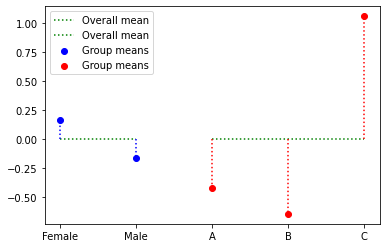

In [11]:
# Show the group means and overall mean.
plot_mean_diffs(diet_cheat_zm, 'gender', 'wlost_zm', 'blue')
plot_mean_diffs(diet_cheat_zm, 'diet', 'wlost_zm', 'red')

Now let us think about the SNSQGMD metric for the `gender` factor.  Remember,
in the one-way ANOVA, this was the weighted sum of the squared group mean
differences.

As a reminder of how the metric works, let's do the calculation long-hand:

In [12]:
# Group means:
gender_means = diet_cheat_zm.groupby('gender')['wlost_zm'].mean()
# Group counts:
gender_counts = diet_cheat_zm.groupby('gender')['wlost_zm'].count()
# Square, multiply by group sizes, and add up to give metric.
gender_snsqgmd = np.sum(gender_counts * (gender_means ** 2))
gender_snsqgmd

1.6334999999999988

We will do this several times, so we use the SNSQGMD function from the one-way notebook to do the same calculation:

In [13]:
def get_sn_sq_gmd(df, group_col, val_col):
    grouped = df.groupby(group_col)[val_col]
    sq_gmd = grouped.mean() ** 2
    return np.sum(sq_gmd * grouped.count())

In [14]:
gender_ss = get_sn_sq_gmd(diet_cheat_zm, 'gender', 'wlost_zm')
gender_ss

1.6334999999999988

This is exactly the `sum_sq` value for `gender` in the ANOVA table above.

Now let us do the same calculation on the `diet` factor:

In [15]:
diet_ss = get_sn_sq_gmd(diet_cheat_zm, 'diet', 'wlost_zm')
diet_ss

34.32033333333332

This is exactly the `sum_sq` value for `diet` in the ANOVA table above.

## Allowing for the other effects

But wait - should we not allow for the effects (means) of `diet` when assessing the effects (means) of `gender`?  And vice-versa?  And if you've been [reading around the topic](https://www.ars.usda.gov/ARSUserFiles/60540520/Two-wayANOVAspreadsheet.pdf), you might know this is exactly what the *type II sum of squares* calculation is meant to do.  We used type II sum of squares in the ANOVA calculation above, with the `typ=2` keyword argument. Let's do that, and see what we get.

Our job now is to *remove* the effect of `diet` before assessing the effect of gender.  We do this by getting the means for each of the three diet levels `A`, `B`, and `C`, and subtracting these means from the values corresponding to diets `A`, `B` and `C`.

Here are the group means for `diet`:

In [16]:
diet_cheat_zm.groupby('diet')['wlost_zm'].mean()

diet
A   -0.418333
B   -0.643333
C    1.061667
Name: wlost_zm, dtype: float64

First we make a new series that replaces the individual values for `wlost_zm` with their corresponding group means.  We can use the Pandas `transform` method of the `groupby` object to do this for us:

In [17]:
# Make a series with the same number of rows as the original data frame
# but where we have, instead of the `wlost_zm` values, we have the 
# group mean for the corresponding diet.
diet_mean_col = diet_cheat_zm.groupby('diet')['wlost_zm'].transform('mean')
diet_mean_col.head()

0   -0.418333
1   -0.418333
2   -0.418333
3   -0.418333
4   -0.418333
Name: wlost_zm, dtype: float64

Next we subtract these diet group means from the `wlost_zm` column, to give the values *left over*  (residual values) after *adjusting for* the `diet` means.

In [18]:
minus_diet = diet_cheat_zm['wlost_zm'] - diet_mean_col
minus_diet.head()

0    0.29
1    2.49
2   -2.81
3   -0.61
4   -0.71
Name: wlost_zm, dtype: float64

We will do this subtracting mean operation a few times, so we put it into a function:

In [19]:
# Put this into a function
def subtract_means(df, group_col, value_col):
    mean_col = df.groupby(group_col)[value_col].transform('mean')
    return df[value_col] - mean_col

Show we get the same result from the function as from the by-hand calculation above:

In [20]:
subtract_means(diet_cheat_zm, 'diet', 'wlost_zm').head()

0    0.29
1    2.49
2   -2.81
3   -0.61
4   -0.71
Name: wlost_zm, dtype: float64

Now we have this diet-adjusted column, we can put it into the data frame, and calculate the SNSQGMD metric.

In [21]:
# Effect of gender, *adjusting for diet*
adj_for_diet = diet_cheat_zm.copy()
adj_col = subtract_means(diet_cheat_zm, 'diet', 'wlost_zm')
adj_for_diet['wlost_adj_diet'] = adj_col
get_sn_sq_gmd(adj_for_diet, 'gender', 'wlost_adj_diet')

1.6335000000000015

How strange - this is *extremely* close to the value we got before adjusting for diet. So close, in fact that the difference looks like the kind of error we typically get from floating point calculations:

In [22]:
(get_sn_sq_gmd(diet_cheat_zm, 'gender', 'wlost_zm') -  # Original
 get_sn_sq_gmd(adj_for_diet, 'gender', 'wlost_adj_diet')) # Adjusted

-2.6645352591003757e-15

As you might imagine, this implies that the means were all but exactly the same before and after adjustment:

In [23]:
# Before adjustment
diet_cheat_zm.groupby('gender')['wlost_zm'].mean()

gender
Female    0.165
Male     -0.165
Name: wlost_zm, dtype: float64

In [24]:
# After adjustment
adj_for_diet.groupby('gender')['wlost_adj_diet'].mean()

gender
Female    0.165
Male     -0.165
Name: wlost_adj_diet, dtype: float64

Yes, that's right - it's a result of the cheating we did further up, in adjusting the groups to each have the same numbers.  In that situation, where the analysis is *balanced*, adjusting each factor for the other has no effect.   Things get more complicated in the much more typical situation, where the group numbers are not the same.

However, in the next step, we will be seeing what is left for the groups to explain, after adjusting for the means of `gender` and `diet`.  Here we are asking - how different are the *remaining* group means, *after* taking into account the overall differences due to `gender` and to `diet`?

To do this, we do need to remove the mean effect of `gender` and of `diet`.

In [25]:
adj_for_gd = diet_cheat_zm.copy()
# Adjust for gender
adj_for_gd['g_adj'] = subtract_means(adj_for_gd, 'gender', 'wlost_zm')
# Adjust for diet.
adj_for_gd['gd_adj'] = subtract_means(adj_for_gd, 'diet', 'g_adj')
adj_for_gd.head()

,gender,diet,wlost_zm,g_adj,gd_adj
0,Female,A,-0.128333,-0.293333,0.125
1,Female,A,2.071667,1.906667,2.325
2,Female,A,-3.228333,-3.393333,-2.975
3,Female,A,-1.028333,-1.193333,-0.775
4,Female,A,-1.128333,-1.293333,-0.875


Now we need to look at the means across the *six* groups, formed by the two levels of `gender` crossed by the three levels of `diet`.  We can form a label for these six groups by combining the labels from the two factors:

In [26]:
adj_for_gd['all_groups'] = adj_for_gd['gender'].str.cat(
    adj_for_gd['diet'], sep='-')
adj_for_gd.head()

,gender,diet,wlost_zm,g_adj,gd_adj,all_groups
0,Female,A,-0.128333,-0.293333,0.125,Female-A
1,Female,A,2.071667,1.906667,2.325,Female-A
2,Female,A,-3.228333,-3.393333,-2.975,Female-A
3,Female,A,-1.028333,-1.193333,-0.775,Female-A
4,Female,A,-1.128333,-1.293333,-0.875,Female-A


Plot the data and means of the adjusted data for each of these six groups:

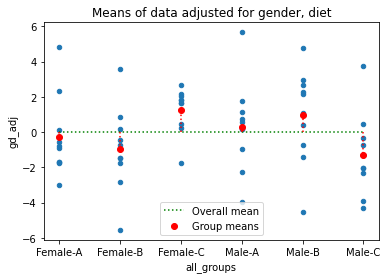

In [27]:
adj_for_gd.plot.scatter('all_groups', 'gd_adj')
plot_mean_diffs(adj_for_gd, 'all_groups', 'gd_adj')
plt.title('Means of data adjusted for gender, diet');

If the effects of `diet` and `gender` explain most of the differences between weight values, then we would expect these remaining mean differences to be small.  If there are other effects, such as bigger changes in some sub-groups than others, then these remaining effects will be large.  These remaining effects are called *interaction* effects.  The are interactions because, when present, they imply that the effects of diet or gender are bigger in some sub-groups than others.  In that situation, we talk of the effects of diet and gender *interacting*.

At this point, it may be obvious what we do to assess the overall size of these remaining mean differences. That's right, we calculate the SNSQGMD metric on them:

In [28]:
inter_ss = get_sn_sq_gmd(adj_for_gd, 'all_groups', 'gd_adj')
inter_ss

53.190999999999995

Notice that this is exactly the same as the `gender:diet` `sum_sq` value in the ANOVA table:

In [29]:
sm.stats.anova_lm(cheat_fit, typ=2)

,sum_sq,df,F,PR(>F)
gender,1.633500,1.0,0.311696,0.578949
diet,34.320333,2.0,3.274413,0.045475
gender:diet,53.191000,2.0,5.074814,0.009559
Residual,282.997000,54.0,NaN,NaN


To get the F-value, we divide the SNSQGMD (`sum_sq`) value by an estimate of the remaining variation.  The remaining variation in this case (type II sum of squares) is what we have left after we've removed everything we can remove with our `gender` and `diet` and `gender:diet` means.

In [30]:
everything_removed = subtract_means(adj_for_gd, 'all_groups', 'gd_adj')
resid_ss = np.sum(everything_removed ** 2)
resid_ss

282.997

Notice this is the `Residual` `sum_sq` value in the table.

Finally we calculate the *degrees of freedom* for each test, and for the remaining variation.  We won't go into details about these:

In [31]:
n_groups = len(adj_for_gd['all_groups'].unique())
df_error = len(adj_for_gd) - n_groups  # D.F. for remaining variation

We replicate all three F values in the ANOVA table above:

In [32]:
df_gender = len(adj_for_gd['gender'].unique()) - 1  # 1
F_gender = (gender_ss / df_gender) / (resid_ss / df_error)
F_gender

0.3116958837019471

In [33]:
df_diet = len(adj_for_gd['diet'].unique()) - 1  # 2
F_diet = (diet_ss / df_diet) / (resid_ss / df_error)
F_diet

3.2744128029625745

In [34]:
# We have already adjusted the interaction values for gender and diet.
df_inter = n_groups - df_gender - df_diet - 1  # 2
F_inter = (inter_ss / df_inter) / (resid_ss / df_error)
F_inter

5.074813513924175

We can look up the p value in the corresponding F distribution.  For example:

In [35]:
# Get standard F distribution object from Scipy.
from scipy.stats import f as f_dist

# Look up interaction p value from corresponding F distribution.
f_dist(df_inter, df_error).sf(F_inter)

0.00955850235834818